## Data preparation

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('course_lead_scoring.csv')
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [3]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [4]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [5]:
categorical_features = ['lead_source', 'industry', 'employment_status', 'location']
numerical_features = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']
for f in categorical_features:
    df[f] = df[f].fillna('NA')

for f in numerical_features:
    df[f] = df[f].fillna(0.0)

In [6]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
y_full_train = df_full_train.converted
y_test = df_test.converted
y_train = df_train.converted
y_val = df_val.converted

In [9]:
numerical_features = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']

## ROC AUC feature importance
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
Use the training dataset for that
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['balance'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- lead_score
- number_of_courses_viewed
- interaction_count
- annual_income

In [10]:
from sklearn.metrics import roc_auc_score

In [11]:
for column in numerical_features:
    score = roc_auc_score(df_train.converted, df_train[column])
    if score < 0.5:
        score = roc_auc_score(df_train.converted, -df_train[column])
    print(f"{column}:", score )

number_of_courses_viewed: 0.7635680590007088
annual_income: 0.5519578313253012
interaction_count: 0.738270176293409
lead_score: 0.6144993577250176


## Training the model
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.32
- 0.52
- 0.72
- 0.92

In [13]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [14]:
df_test = df_test.drop(columns= ['converted'])
df_train = df_train.drop(columns=['converted'])
df_val = df_val.drop(columns=['converted'])

In [15]:
features = categorical_features + numerical_features

# Train
dicts = df_train[features].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dicts)
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

# Predict
dicts = df_val[features].to_dict(orient='records')
X_val = dv.fit_transform(dicts)
y_pred = model.predict_proba(X_val)[:, 1]

auc = round(roc_auc_score(y_val, y_pred), 3)
auc

0.817

## Precision and Recall
Now let's compute precision and recall for our model.

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
For each threshold, compute precision and recall
Plot them
At which threshold precision and recall curves intersect?

- 0.145
- 0.345
- 0.545
- 0.745

In [16]:
import numpy as np
from matplotlib import pyplot as plt

0.64


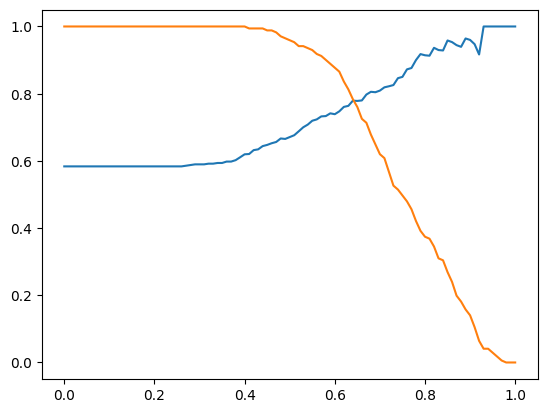

In [17]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

thresholds = []
precissions = []
recalls = []

for threshold in np.linspace(0, 1, 100):
    threshold = round(threshold, 2)
    thresholds.append(threshold)
    predict_positive = (y_pred >= threshold)
    predict_negative = (y_pred < threshold)
    # True positives
    tp = (predict_positive & actual_positive).sum()
    # False positives
    fp = (predict_positive & actual_negative).sum()
    # False negatives
    fn = (predict_negative & actual_positive).sum()
    # Precission
    if tp + fp > 0:
        precission = tp / (tp + fp)
    
    if tp + fn > 0:
        recall = tp / (tp + fn)

    precissions.append(precission)
    recalls.append(recall)

    if round(precission, 2) == round(recall, 2):
        print(threshold)

plt.plot(thresholds, precissions, label='Precission')
plt.plot(thresholds, recalls, label = "Recall")

## F1 score
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

In [18]:
f1_scores = []
for i in range(len(thresholds)):
    f1 = 2 * ((precissions[i] * recalls[i]) / (precissions[i] + recalls[i]))
    f1_scores.append(f1)

thresholds[f1_scores.index(max(f1_scores))]

np.float64(0.57)

## 5-Fold CV
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)
Iterate over different folds of df_full_train
Split the data into train and validation
Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
Use AUC to evaluate the model on validation
How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.36

In [19]:
from sklearn.model_selection import KFold

In [20]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.converted
    y_val = df_val.converted

    df_train = df_train.drop(columns=['converted'])
    df_val = df_val.drop(columns=['converted'])

    # Train
    dicts = df_train[features].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    # Predict
    dicts = df_val[features].to_dict(orient='records')
    X_val = dv.fit_transform(dicts)
    y_pred = model.predict_proba(X_val)[:, 1]

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.822 +- 0.036


## Hyperparameter Tuning
Now let's use 5-Fold cross-validation to find the best parameter C

Iterate over the following C values: [0.000001, 0.001, 1]
Initialize KFold with the same parameters as previously
Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
Compute the mean score as well as the std (round the mean and std to 3 decimal digits)
Which C leads to the best mean score?

- 0.000001
- 0.001
- 1

In [21]:
for C in [0.000001, 0.001, 1]:
    scores = []

    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        df_train = df_train.drop(columns=['converted'])
        df_val = df_val.drop(columns=['converted'])

        # Train
        dicts = df_train[features].to_dict(orient='records')
        dv = DictVectorizer(sparse=False)
        X_train = dv.fit_transform(dicts)
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)
        
        # Predict
        dicts = df_val[features].to_dict(orient='records')
        X_val = dv.fit_transform(dicts)
        y_pred = model.predict_proba(X_val)[:, 1]

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    
    print('%f: %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

0.000001: 0.560 +- 0.024
0.001000: 0.867 +- 0.029
1.000000: 0.822 +- 0.036
